In [1]:
import sys,os
os.environ['pRT_input_data_path'] = '/Users/nasedkin/python-packages/petitRADTRANS/petitRADTRANS/input_data/'
os.environ["OMP_NUM_THREADS"] = "1"
import numpy as np
import pandas as pd
import copy as cp
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.lines import Line2D

from petitRADTRANS import Radtrans
from petitRADTRANS.retrieval.util import *
import petitRADTRANS.retrieval.plot_style as ps
from glob import glob
import scicomap as sc
matplotlib.rcParams['axes.linewidth'] = 2
import json

version = "v01"
map_538 = sc.ScicoQualitative(cmap='538')
fixed_cmap_538 = map_538.get_mpl_color_map()
colour_dict = {"b":fixed_cmap_538(3/6),
              "c":fixed_cmap_538(2/6),
              "d":fixed_cmap_538(1/6),
              "e":fixed_cmap_538(0/6)}
              

species v0.6.0
Working folder: /Users/nasedkin/Documents/Paper2_HR8799_Notebooks
Configuration settings:
   - Database: /Users/nasedkin/Documents/Paper2_HR8799_Notebooks/species_database.hdf5
   - Data folder: /Users/nasedkin/Documents/Paper2_HR8799_Notebooks/data
   - Interpolation method: linear
   - Magnitude of Vega: 0.03
Using pRT Plotting style!


In [2]:
def c_to_o_from_abundances(samples):
    co = 10**samples["CO_all_iso_HITEMP"]
    h2o = 10**samples["H2O_Exomol"]
    h2 = 0.73 * (1.0-(co + h2o))
    he = 0.24 * (1.0-(co + h2o))
    abunds = {"CO_all_iso": co, "H2O": h2o, "H2": h2, "He":he}
    nfracs = mass_to_number(abunds)
    freeco = nfracs["CO_all_iso"]/(nfracs["CO_all_iso"]+ nfracs["H2O"])
    samples["C/O"] = freeco
    return 
    
def calculate_gravity_params(samples):
    gravity = -np.inf
    R_pl = -np.inf
    if 'log_g' in samples.columns and 'mass' in samples.columns:
        gravity = 10**samples['log_g']
        R_pl = np.sqrt(nc.G*samples['mass']/gravity)
        samples["R_pl"] = R_pl
    elif 'log_g' in samples.columns:
        gravity= 10**samples['log_g']
        R_pl = samples['R_pl']
        samples["mass"] = gravity *R_pl**2 / nc.G
    elif 'mass' in samples.columns:
        R_pl = samples['R_pl']
        gravity = nc.G * samples['mass']/R_pl**2
        samples["log_g"] = np.log10(gravity)
    else:
        print("Pick two of log_g, R_pl and mass!")
    return


def sample_teff(pRT_Object, sample, distance = 10.0*nc.pc, name = ""):
    r"""
    This function samples the outputs of a retrieval and computes Teff
    for each sample. For each sample, a model is computed at low resolution,
    and integrated to find the total radiant emittance, which is converted into
    a temperature using the stefan boltzmann law: $j^{\star} = \sigma T^{4}$.
    Teff itself is computed using util.calc_teff.

    Args:
        sample_dict : dict
            A dictionary, where each key is the name of a retrieval, and the values
            are the equal weighted samples.
        param_dict : dict
            A dictionary where each key is the name of a retrieval, and the values
            are the names of the free parameters associated with that retrieval.
        ret_names : Optional(list(string))
            A list of retrieval names, each should be included in the sample_dict.
            If left as none, it defaults to only using the current retrieval name.
        nsample : Optional(int)
            The number of times to compute Teff. If left empty, uses the "take_PTs_from"
            plot_kwarg. Recommended to use ~300 samples, probably more than is set in
            the kwarg!
        resolution : int
            The spectra resolution to compute the models at. Typically, this should be very
            low in order to enable rapid calculation.
    Returns:
        tdict : dict
            A dictionary with retrieval names for keys, and the values are the calculated
            values of Teff for each sample.
    """
    teffs = []
    #rands = np.random.randint(0, samples.shape[0], nsample)
    duse = self.data[self.rd.plot_kwargs["take_PTs_from"]]
    for row in samples.iterrows():
        params = {}
        for key in sample.columns:
            params[key] = sample[rint][key]
        retVal = duse.model_generating_function(pRT_Object,
                                                params,
                                                False,
                                                False)
        if len(retVal) == 2:
            wlen, model = retVal
        else:
            wlen, model, __ = retVal

        tfit = teff_calc(wlen, model, distance, params["R_pl"])
        teffs.append(tfit)
    teffs = np.array(teffs)
    sample["Teff"] = teffs
    np.save(f"retrieval_output_arrays/{name}_sampled_teff", np.array(teffs))

/Users/nasedkin/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
data_dir = "/Users/nasedkin/Documents/RetrievalResults/HR8799_2023_Retrievals/"

planets = ["e"]

samples = {}
names = []

calc_teff = False
resolution = 40
line_species = ['H2O_Exomol', 
                'CO_all_iso_HITEMP', 
                'CH4', 
                'CO2', 
                'NH3', 
                'HCN',
                'H2S', 
                'FeH',
                'PH3', 
                'Na_allard', 
                'K_allard', 
                'TiO_all_Exomol', 
                'VO',
                'SiO']
for count,planet in enumerate(planets):
    full_list = sorted(glob(f"{data_dir}{planet}_full/out_PMN/*post_equal_weights*"))
    free_list = sorted(glob(f"{data_dir}{planet}_free/out_PMN/*post_equal_weights*"))
 
    for f in full_list:
        short = f.split("_post_equal_weights")[0]
        name = short.split("/")[-1]
        pars = json.load(open(short+'_params.json'))
        pars.append("log_likelihood")
        sample = pd.read_csv(f, delim_whitespace=True,names=pars)
        if sample.shape[0] < 100:
            print("Need more than 100 sample in post equal weights!")
            continue
        names.append(name)
        # Setup the pRT object
        resolution = 40
        

        continuum_opacities = ['H2-H2', 'H2-He']  
        rayleigh_species = ['H2', 'He']  

        """species = []
        for line in line_species:
            if not os.path.isdir(os.environ['pRT_input_data_path'] + "opacities/lines/corr_k/"
                                    + line + "_R_"
                                    + str(resolution)):
                species.append(line)

        # If not, setup low-res c-k tables
        if len(species) > 0:
            print("Exo-k should only be run on a single thread.")
            print("The retrieval should be run once on a single core to build the c-k\n"
                    "tables, and then again with multiple cores for the remainder of the retrieval.")
            # Automatically build the entire table
            bin_species_exok(species, resolution)"""

        species = []
        for spec in line_species:
            species.append(spec + "_R_" + str(resolution))
        
        if calc_teff:
            if os.path.exists(f"retrieval_output_arrays/{name}_sampled_teff.npy"):
                teff = np.load(f"retrieval_output_arrays/{name}_sampled_teff.npy")
                sample["Teff"] = teff
            else:
                cloud_species = []
                for key in sample.columns:
                    if "(c)" in key:
                        cname = key.split('_')[-1] + "_cd"
                        if not cname in cloud_species:
                            cloud_species.append(cname)
                            
                pressures = np.logspace(-6,3,100)
                prt_object = Radtrans(line_species=cp.copy(species),
                                        rayleigh_species=cp.copy(rayleigh_species),
                                        continuum_opacities=cp.copy(continuum_opacities),
                                        cloud_species=cp.copy(cloud_species),
                                        mode='c-k',
                                        wlen_bords_micron=[0.5, 28],
                                        do_scat_emis=True)
                sample_teff(prt_object, sample, distance = 10.0*nc.pc, name = name)
        calculate_gravity_params(sample)
        samples[name] = sample
    for f in free_list:
        short = f.split("_post_equal_weights")[0]
        name = short.split("/")[-1]
        pars = json.load(open(short+'_params.json'))
        pars.append("log_likelihood")

        sample = pd.read_csv(f, delim_whitespace=True,names=pars)
        if sample.shape[0] < 100:
            print("Need more than 100 sample in post equal weights!")
            continue
        if planet =="b" and not "correctos" in name:
            continue
        c_to_o_from_abundances(sample)
        calculate_gravity_params(sample)
        if calc_teff:
            if os.path.exists(f"retrieval_output_arrays/{name}_sampled_teff.npy"):
                teff = np.load(f"retrieval_output_arrays/{name}_sampled_teff.npy")
                sample["Teff"] = teff
            else:
                cloud_species = []
                species = []
                for key in sample.columns:
                    if "(c)" in key:
                        cname = key.split('_')[-1] + "_cd"
                        if not cname in cloud_species:
                            cloud_species.append(cname)
                    if key in line_species:
                        species.append(species + "_R_" + str(resolution))
                            
                pressures = np.logspace(-6,3,100)
                prt_object = Radtrans(line_species=cp.copy(species),
                                        rayleigh_species=cp.copy(rayleigh_species),
                                        continuum_opacities=cp.copy(continuum_opacities),
                                        cloud_species=cp.copy(cloud_species),
                                        mode='c-k',
                                        wlen_bords_micron=[0.5, 28],
                                        do_scat_emis=True)
                sample_teff(prt_object, sample, distance = 10.0*nc.pc, name = name)
        names.append(name)
        samples[name] = sample
     


/Users/nasedkin/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Need more than 100 sample in post equal weights!


In [107]:
samples[names[-2]].columns

/Users/nasedkin/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['log_g', 'R_pl', 'gamma', 'T0', 'T1', 'T2', 'log_kzz', 'fsed',
       'sigma_lnorm', 'OSIRIS2011_scale_factor', 'H2O_Exomol',
       'CO_all_iso_HITEMP', 'CH4', 'CO2', 'HCN', 'H2S', 'log_X_cb_MgSiO3(c)',
       'log_Pbase_MgSiO3(c)', 'log_likelihood', 'C/O'],
      dtype='object')

In [4]:
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

def make_violin_plot(sample_dict, 
                     retrieval_list, 
                     parameter, 
                     facecolour = 'tab:blue', 
                     linecolour = 'k', 
                     labels = None, 
                     ylabel = None, 
                     planet = "",
                     tag = "",
                     normalize = 1):
    fig, ax = plt.subplots(figsize = (12,12))
    data = []
    label_dict = {}
    label_dict["C/O"] = "C/O"
    label_dict["Fe/H"] = "[Z/H]"
    label_dict["H2O_Exomol"] = "Water Mass Fraction"
    label_dict["CO_all_iso_HITEMP"] = "CO Mass Fraction"
    label_dict["CH4"] = "CH4"
    label_dict["log_g"] = r"$\log g$ [cgs]"
    label_dict["R_pl"] = r"Radius [R$_{\rm Jup}$]"
    label_dict["mass"] = r"Mass [M$_{\rm Jup}$]"
    label_dict["Teff"] = r"T$_{\rm Eff}$ [K}]"





    labels_use = []
    for i,name in enumerate(retrieval_list):
        if name in sample_dict.keys():
            if parameter in sample_dict[name].columns:
                data.append(sample_dict[name][parameter].to_numpy()/normalize)
                if labels is not None:
                    labels_use.append(labels[i])
                else:
                    labels_use.append(name)
        else:
            continue

    if len(data) == 0:
        print("No data to plot! Did you input a valid parameter? {parameter}")
        return

    posns = np.linspace(1, 1.1*len(data)+1, len(data))
    parts = ax.violinplot(data, 
                          points = 1000,
                          showmedians=True,
                          quantiles = [[0.159,0.841] for i in range(len(data))],
                          showextrema=False,
                          positions = posns)

    for pc in parts['bodies']:
        pc.set_facecolor(facecolour)
        pc.set_edgecolor('k')
        pc.set_alpha(1)
    parts['cmedians'].set_color(linecolour)
    parts['cquantiles'].set_color(linecolour)

    quantile1, medians, quantile3 = [],[],[]
    for d in data:
        q1, m, q3 = np.quantile(d, [0.159, 0.50, 0.841])
        quantile1.append(q1)
        medians.append(m)
        quantile3.append(q3)
    whiskers = np.array([
        adjacent_values(sorted_array, q1, q3)
        for sorted_array, q1, q3 in zip(data, quantile1, quantile3)])
    whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

    #ax2.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
    ax.vlines(posns, quantile1, quantile3, color=linecolour, linestyle='-', lw=3, alpha = 0.7)
    #ax2.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)
    #custom_lines = [Line2D([0], [0], color=colour_dict["e"], lw=4),
    #                Line2D([0], [0], color=colour_dict["d"], lw=4),
    #                Line2D([0], [0], color=colour_dict["c"], lw=4),
    #                Line2D([0], [0], color=colour_dict["b"], lw=4)]
    #ax.legend(custom_lines, ['HR 8799 e', 'HR 8799 d', 'HR 8799 c','HR 8799 b'],loc = 'lower right')

    ax.set_xlim(0.5,posns[-1]+1.5)
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    elif parameter in label_dict.keys():
        ax.set_ylabel(label_dict[parameter])
    else:
        ax.set_ylabel(parameter)

    ax.set_xticks(posns)
    ax.set_xticklabels(labels_use, rotation = 90, fontsize = 12)
    #ax.set_xlabel("Varying Models + Data Inclusion")
    plt.savefig(f"plots/HR8799{planet}_{parameter.replace('/','_')}_violinplot_{tag}_{version}.pdf",bbox_inches='tight')

/Users/nasedkin/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
short_names_b = ["Clear",
               "Fe Cloud (eq)",
               "MgSiO3 Cloud (eq)",
               "Fe + MgSiO3 Clouds (eq)",
               "Fe + MgSiO3 Cloud (eq), Mass Prior",
               "Fe + MgSiO3 Cloud (eq), Mass Prior, New phot",
               "Fe + MgSiO3 Cloud (eq), Mass Prior, New phot, Broad Fe/H",
               "Fe + MgSiO3 Cloud (free), Mass Prior, New phot, Broad Fe/H",
               "Na2S Cloud (eq), Mass Prior, New phot",
               "Free, Clear, 2 Nodes",
               "Free, Clear, 3 Nodes",
               "Free, Clear, 4 Nodes",
               "Free, Clear, 5 Nodes",
               "Free, Clear, 6 Nodes",
               "Free, Clear, 7 Nodes",
               "Free, Clear, 8 Nodes",
               "Free, Clear, 9 Nodes",
               "Free, MgSiO3 Cloud (free), 2 Nodes",
               "Free, MgSiO3 Cloud (free), 3 Nodes",
               "Free, MgSiO3 Cloud (free), 4 Nodes",
               "Free, MgSiO3 Cloud (free), 5 Nodes",
               "Free, MgSiO3 Cloud (free)",
               ]
retrievals_b = ['HR8799b_23_v02_diseq_all_scaleos_clear', 
              'HR8799b_23_v02_diseq_all_scaleos_eqFeCloud', 
              'HR8799b_23_v02_diseq_all_scaleos_eqMgCloud', 
              'HR8799b_23_v02_diseq_all_scaleos_eqFeMgCloud', 
              'HR8799b_23_v02_diseq_all_scaleos_eqFeMgCloud_mrprior', 
              'HR8799b_23_v03_diseq_all_scaleos_eqFeMgCloud_mrprior_newdata_newphot',
              'HR8799b_23_v03_diseq_all_scaleos_eqFeMgCloud_mrprior_highfeh_fseds', 
              'HR8799b_23_v02_diseq_all_scaleos_eqNa2SCloud_mrprior_newdata_newphot', 
              'HR8799b_23_v02_diseq_all_scaleos_freeFeMgCloud_mrprior_newdata_newphot', 
              'HR8799b_23_v01_free_all_correctos_clear_0nodes_v2', 
              'HR8799b_23_v01_free_all_correctos_clear_1nodes_v2', 
              'HR8799b_23_v01_free_all_correctos_clear_2nodes_v2', 
              'HR8799b_23_v01_free_all_correctos_clear_3nodes_v2', 
              'HR8799b_23_v01_free_all_correctos_clear_4nodes_v2', 
              'HR8799b_23_v01_free_all_correctos_clear_5nodes_v2', 
              'HR8799b_23_v01_free_all_correctos_clear_6nodes_v2', 
              'HR8799b_23_v01_free_all_correctos_clear_7nodes_v2', 
              'HR8799b_23_v01_free_all_correctos_freeMgCloud_0nodes_v4',
              'HR8799b_23_v01_free_all_correctos_freeMgcloud_1nodes_v4',
              'HR8799b_23_v01_free_all_correctos_freeMgCloud_2nodes_v4', 
              'HR8799b_23_v01_free_all_correctos_freeMgCloud_3nodes_v4', 
              'HR8799b_23_v01_free_all_correctos_freeMgCloud_guillot' ]

retrievals_e = ['HR8799e_23_v01_diseq_onlygrav_clear',
                'HR8799e_23_v01_diseq_onlygravphot_clear', 
                'HR8799e_23_v01_diseq_onlygrav_eqMgCloud', 
                'HR8799e_23_v01_diseq_onlygravphot_eqMgCloud',
                'HR8799e_23_v01_diseq_onlygravphot_eqMgCloud_mrprior',
                'HR8799e_23_v01_diseq_all_eqFeMgCloud',
                'HR8799e_23_v01_diseq_all_eqFeMgCloud_mrprior', 
                'HR8799e_23_v01_diseq_all_eqFeMgCloud_bothfseds', 
                'HR8799e_23_v01_diseq_all_eqFeMgCloud_bothfseds_newphot', 
                'HR8799e_23_v01_diseq_all_eqFeMgCloud_newphot_newSPH_fseds_mrprior', 
                'HR8799e_23_v01_diseq_all_eqFeMgCloud_patchy_newphot', 
                'HR8799e_23_v01_diseq_all_eqFeMgCloud_grad_newphot',
                'HR8799e_23_v01_diseq_all_eqFeMgCloud_spline_newphot', 
                'HR8799e_23_v01_diseq_nocharis_eqFeMgCloud_bothfseds', 
                'HR8799e_23_v01_diseq_nogpi_eqFeMgCloud_bothfseds', 
                'HR8799e_23_v01_diseq_nograv_eqFeMgCloud_bothfseds', 
                'HR8799e_23_v01_diseq_nosph_eqFeMgCloud_bothfseds', 
                'HR8799e_23_v03_free_onlygrav_clear_guillot', 
                'HR8799e_23_v03_free_onlygravphot_clear_guillot', 
                'HR8799e_23_v03_free_onlygrav_freeMgCloud_guillot', 
                'HR8799e_23_v03_free_onlygravphot_freeMgCloud_guillot_mrprior', 
                'HR8799e_23_v03_free_onlygravphot_freeFeCloud_guillot',
                'HR8799e_23_v03_free_onlygravphot_freeMgCloud_guillot'
                'HR8799e_23_v01_free_all_clear_guillot', 
                'HR8799e_23_v01_free_all_freeMgCloud_guillot',
                'HR8799e_23_v01_free_gravphot_freeMgCloud_guillot_mrsigmaprior',
                'HR8799e_23_v01_free_all_freeMg2Cloud_guillot_newphot_newconv', 
                'HR8799e_23_v01_free_all_freeAl2Cloud_guillot_newphot_newconv', 
                'HR8799e_23_v01_free_all_freeSiCCloud_guillot_newphot_newconv',
                'HR8799e_23_v01_free_all_freeFeMgCloud_guillot', 
                'HR8799e_23_v01_free_all_freeFeMgCloud_guillotfseds_newphot_newconv', 
                'HR8799e_23_v01_free_all_freeFeMgCloud_guillotpatchy_newphot_newconv', 
                'HR8799e_23_v01_free_all_freeFeMgCloud_spline_newphot_newconv']

retrievals_c = [#'HR8799c_23_v01_diseq_onlygrav_noos_clear', # bad logg
                'HR8799c_23_v01_diseq_onlygravphot_noos_clear_logg', 
                #'HR8799c_23_v01_diseq_onlygravphot_noos_clear',# bad logg
                'HR8799c_23_v01_diseq_onlygrav_noos_clear_logg', 
                #'HR8799c_23_v01_diseq_onlygrav_noos_eqFeCloud', # bad logg
                #'HR8799c_23_v01_diseq_onlygravphot_noos_eqFeCloud', # bad logg
                'HR8799c_23_v01_diseq_onlygrav_noos_eqMgCloud_logg',
                'HR8799c_23_v01_diseq_onlygravphot_noos_eqMgCloud_logg', 
                #'HR8799c_23_v01_diseq_onlygrav_noos_eqMgCloud',# bad logg
                #'HR8799c_23_v01_diseq_onlygravphot_noos_eqMgCloud', # bad logg
                'HR8799c_23_v01_diseq_onlygravphot_noos_eqMgCloud_mrprior',
                #'HR8799c_23_v01_diseq_onlygrav_noos_eqFeMgCloud', # bad logg
                'HR8799c_23_v01_diseq_all_grav_eqFeMgCloud_logg_fseds_newbins_newphot', 
                'HR8799c_23_v01_diseq_all_noos_eqFeMgCloud_logg', 
                #'HR8799c_23_v01_diseq_nogpi_noos_eqFeMgCloud',# bad logg
                'HR8799c_23_v01_diseq_all_noos_patchyeqFeMgCloud_logg_newbins_newphot', 
                'HR8799c_23_v01_diseq_all_osbin_patchyeqFeMgCloud_logg_newbins_newphot', 
                'HR8799c_23_v03_free_all_onlygrav_nogpi_clear_guillot', 
                'HR8799c_23_v03_free_all_onlygrav_withphot_nogpi_clear_guillot',
                'HR8799c_23_v03_free_all_onlygravphot_nogpi_freeFeCloud_guillot', 
                'HR8799c_23_v03_free_all_onlygrav_nogpi_eqMgCloud_guillot', 
                'HR8799c_23_v03_free_all_onlygrav_nogpi_freeMgCloud_guillot', 
                'HR8799c_23_v03_free_all_onlygravphot_nogpi_freeMgCloud_guillot', 
                'HR8799c_23_v03_free_all_onlygravphot_nogpi_freeFeMgCloud_guillot', 
                'HR8799c_23_v03_free_all_all_noos_freeFeMgCloud_guillot', 
                'HR8799c_23_v03_free_all_all_noos_freeMgCloud_guillot', 
                'HR8799c_23_v03_free_nograv_os_freeFeMgCloud_guillot_newphot']

retrievals_d = ['HR8799d_23_v01_diseq_onlygrav_clear', 
                'HR8799d_23_v01_diseq_onlygravphot_eqFeCloud', 
                'HR8799d_23_v01_diseq_onlygravphot_eqMgCloud', 
                'HR8799d_23_v01_diseq_onlygravphot_eqFeMgCloud_mrprior', 
                'HR8799d_23_v01_diseq_onlygravphot_eqFeMgCloud', 
                'HR8799d_23_v01_diseq_all_eqFeMgCloud_fseds_newconv_newphot', 
                'HR8799d_23_v01_diseq_all_noales_eqFeMgCloud_newconv', 
                'HR8799d_23_v01_diseq_all_nocharis_eqFeMgCloud_newconv_newphot', 
                'HR8799d_23_v01_diseq_all_nogpi_eqFeMgCloud_newconv', 
                'HR8799d_23_v01_diseq_all_nograv_eqFeMgCloud_newconv', 
                'HR8799d_23_v01_diseq_all_nosph_eqFeMgCloud', 
                'HR8799d_23_v01_diseq_all_nosphfull_eqFeMgCloud', 
                'HR8799d_23_v01_diseq_all_shortsph_eqFeMgCloud', 
                'HR8799d_23_v03_free_onlygrav_clear_guillot', 
                'HR8799d_23_v03_free_onlygravphot_clear_guillot', 
                'HR8799d_23_v03_free_onlygravphot_clear_free_MgCloud_guillot', 
                'HR8799d_23_v04_free_onlygravphot_free_MgCloud_guillot',
                'HR8799d_23_v04_free_all_freeFeMgCloud_guillot', 
                'HR8799d_23_v04_free_all_eqFeMgCloud_guillot_fseds' 
                ]

/Users/nasedkin/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/nasedkin/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


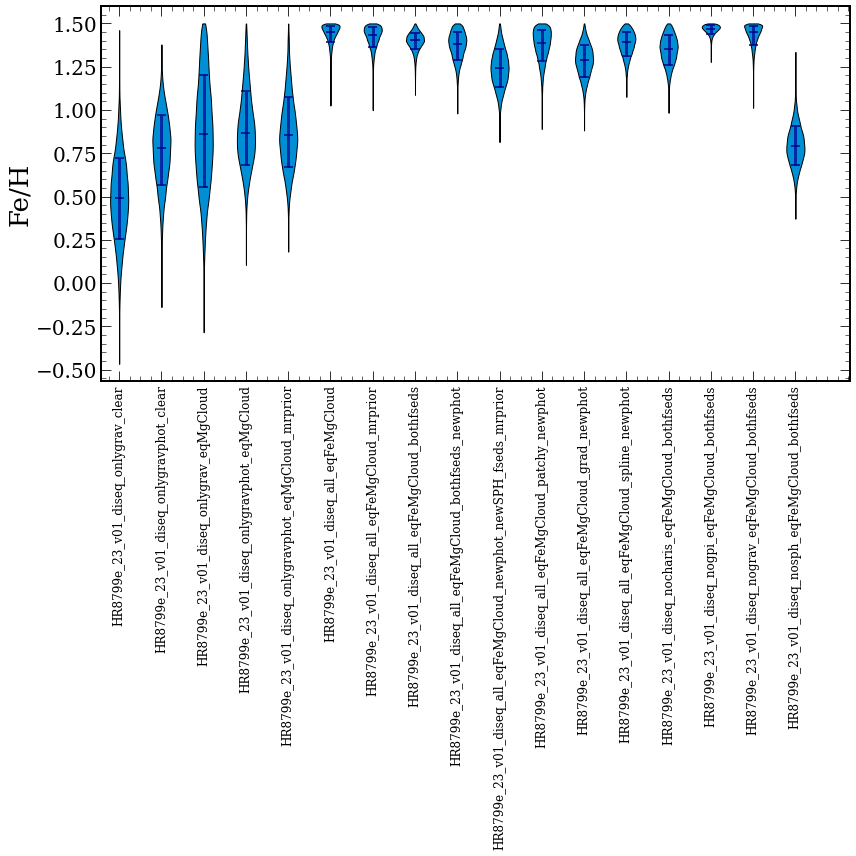

In [12]:
make_violin_plot(samples,
                 retrievals_e, 
                 "Fe/H", 
                 facecolour=colour_dict["e"], 
                 linecolour = 'darkblue',
                 labels = None,
                 planet = "e",
                 normalize = 1)

In [165]:
samples.keys()


/Users/nasedkin/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


dict_keys(['HR8799d_23_v01_diseq_all_eqFeMgCloud_fseds_newconv_newphot', 'HR8799d_23_v01_diseq_all_noales_eqFeMgCloud_newconv', 'HR8799d_23_v01_diseq_all_nocharis_eqFeMgCloud_newconv_newphot', 'HR8799d_23_v01_diseq_all_nogpi_eqFeMgCloud_newconv', 'HR8799d_23_v01_diseq_all_nograv_eqFeMgCloud_newconv', 'HR8799d_23_v01_diseq_all_nosph_eqFeMgCloud', 'HR8799d_23_v01_diseq_all_nosphfull_eqFeMgCloud', 'HR8799d_23_v01_diseq_all_shortsph_eqFeMgCloud', 'HR8799d_23_v01_diseq_onlygrav_clear', 'HR8799d_23_v01_diseq_onlygravphot_eqFeCloud', 'HR8799d_23_v01_diseq_onlygravphot_eqFeMgCloud_mrprior', 'HR8799d_23_v01_diseq_onlygravphot_eqFeMgCloud', 'HR8799d_23_v01_diseq_onlygravphot_eqMgCloud', 'HR8799d_23_v03_free_onlygrav_clear_guillot', 'HR8799d_23_v03_free_onlygravphot_clear_free_MgCloud_guillot', 'HR8799d_23_v03_free_onlygravphot_clear_guillot', 'HR8799d_23_v04_free_all_eqFeMgCloud_guillot_fseds', 'HR8799d_23_v04_free_all_freeFeMgCloud_guillot', 'HR8799d_23_v04_free_onlygravphot_free_MgCloud_guillo